<a href="https://colab.research.google.com/github/KIMCAT33/Tensorflow-2.0/blob/master/Keras_Fashion_MNIST_(TPU_%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## Fashion MNIST with Keras and TPUs

## Overview

이 예제에서, tf.keras와 Cloud TPU를 이용하여 fashion MNIST dataset을 훈련시켜볼 것입니다. 모델은 Cloud TPU를 이용해 10 epochs만큼 훈련할 것인데 약 2분 정도 걸립니다. 


<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

 메인 메뉴에서, Runtime을 누르고 **Change runtime type**을 선택해서 TPU로 셋팅해줍니다. 

TPUs는 구글 클라우드 상에 있으며, TPU는 최적의 성능을 위해 Google Cloud Storage(GCS)로부터 바로 데이터를 읽습니다. 

## Data, model, and training

tf.keras.datasets을 통해 fashion MNIST dataset을 아래와 같이 다운로드해야합니다. 

In [0]:
import tensorflow as tf
import numpy as np

import distutils
if distutils.version.LooseVersion(tf.__version__) < '1.14':
    raise Exception('This notebook is compatible with TensorFlow 1.14 or higher, for TensorFlow 1.13 or lower please use the previous version at https://github.com/tensorflow/tpu/blob/r1.13/tools/colab/fashion_mnist.ipynb')

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# add empty color dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

### 모델 정의하기
다음 예제에서 각 층에 오버피팅을 막기 위한 드롭아웃 층과 배치정규화층을 가진 3개의 층으로 이루어진 일반적인 conv-net을 사용할겁니다.

In [0]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model

### TPU로 훈련하기

훈련을 시작하기 위해, TPU 상에서 모델을 구축하고 컴파일해보죠.

In [3]:
import os

resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.contrib.distribute.initialize_tpu_system(resolver)
strategy = tf.contrib.distribute.TPUStrategy(resolver)

with strategy.scope():
  model = create_model()
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])



INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.26.222.202:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6656212332753690321)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 4402255158305625705)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 852188089125362025)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 8245749460047452665)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 17179

In [9]:
 #텐서보드 설정
 LOG_DIR = '/tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2019-09-30 00:41:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.164.252.120, 52.204.38.150, 3.223.119.4, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.164.252.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  12.98M  39.3MB/s    in 0.3s    

2019-09-30 00:41:00 (39.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   
https://016ec15f.ngrok.io


In [0]:
tb_hist = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR,
                                      histogram_freq=0,
                                      write_graph=True,
                                      write_images=True)

In [8]:
model.fit(
    x_train.astype(np.float32), y_train.astype(np.float32),
    epochs=17,
    steps_per_epoch=60,
    validation_data=(x_test.astype(np.float32), y_test.astype(np.float32)),
    validation_freq=17,
    callbacks=[tb_hist]
)

model.save_weights('./fashion_mnist.h5', overwrite=True)

Epoch 1/17
60/60 [==============================] - 5s 77ms/step - loss: 0.0481 - sparse_categorical_accuracy: 0.9824
Epoch 2/17
60/60 [==============================] - 1s 24ms/step - loss: 0.0450 - sparse_categorical_accuracy: 0.9836
Epoch 3/17
60/60 [==============================] - 1s 23ms/step - loss: 0.0468 - sparse_categorical_accuracy: 0.9825
Epoch 4/17
60/60 [==============================] - 1s 24ms/step - loss: 0.0470 - sparse_categorical_accuracy: 0.9824
Epoch 5/17
60/60 [==============================] - 1s 24ms/step - loss: 0.0467 - sparse_categorical_accuracy: 0.9824
Epoch 6/17
60/60 [==============================] - 1s 24ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9849
Epoch 7/17
60/60 [==============================] - 1s 24ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9845
Epoch 8/17
60/60 [==============================] - 1s 24ms/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9857
Epoch 9/17
60/60 [==============================] - 1s 2

### 결과 확인하기 (별첨)
이제 훈련을 끝냈습니다, 우리의 모델이 얼마나 예측을 잘하는지 확인해보죠.

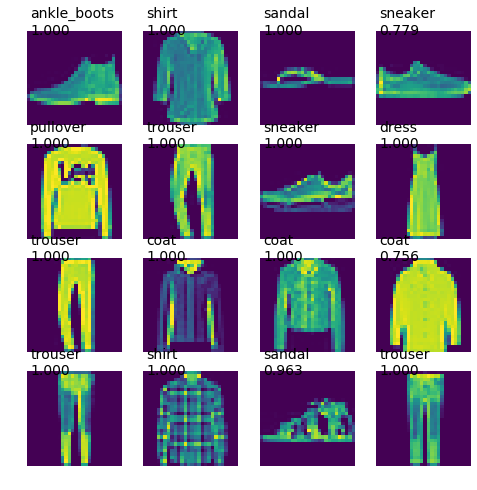

In [10]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


cpu_model = create_model()
cpu_model.load_weights('./fashion_mnist.h5')

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(x_test[:16]), 
                 cpu_model.predict(x_test[:16]))